In [3]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

def summary(ndarr):
    print(ndarr)
    print("* shape: {}".format(ndarr.shape))
    print("* min: {}".format(np.min(ndarr)))
    print("* max: {}".format(np.max(ndarr)))
    print("* avg: {}".format(np.mean(ndarr)))
    print("* std: {}".format(np.std(ndarr)))
    print("* unique: {}".format(np.unique(ndarr)))

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def plot_fatten_img(ndarr):
    img = ndarr.copy()
    img.shape = (28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [65]:
class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[128,64],alpha=0.0):
        self.n_features = n_features
        
        self.weights = None
        self.biases = None
        
        self.graph = tf.Graph() # initialize new grap
        self.build(n_features,learning_rate,n_hidden,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,n_features))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss, _ = self.structure(
                                               features=self.train_features,
                                               n_hidden=n_hidden)
            
            # regularization loss
            # weight elimination L2 regularizer
            self.regularizer = tf.reduce_sum([tf.reduce_sum(
                        tf.pow(w,2)/(1+tf.pow(w,2))) for w in self.weights.values()]) \
                    / tf.reduce_sum(
                     [tf.size(w,out_type=tf.float32) for w in self.weights.values()])
                                                                    
            # total loss
            self.loss = self.original_loss + alpha * self.regularizer
            
            # define training operation
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            
            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.new_y_, self.new_original_loss, self.new_encode = self.structure(
                                                          features=self.new_features,
                                                          n_hidden=n_hidden)  
            self.new_loss = self.new_original_loss + alpha * self.regularizer
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()  
    
    def structure(self,features,n_hidden):
        ### Variable
        if (not self.weights) and (not self.biases):
            self.weights = {
                'encode1': tf.Variable(tf.truncated_normal(
                    shape=(self.n_features,n_hidden[0])),dtype=tf.float32), 
                'encode2': tf.Variable(tf.truncated_normal(
                    shape=(n_hidden[0],n_hidden[1])),dtype=tf.float32),
                'decode1': tf.Variable(tf.truncated_normal(
                    shape=(n_hidden[1],n_hidden[0])),dtype=tf.float32),
                'decode2': tf.Variable(tf.truncated_normal(
                    shape=(n_hidden[0],self.n_features)),dtype=tf.float32),    
            }
            self.biases  = {
                'encode1': tf.Variable(tf.zeros( shape=(n_hidden[0]) ),dtype=tf.float32),
                'encode2': tf.Variable(tf.zeros( shape=(n_hidden[1]) ),dtype=tf.float32),
                'decode1': tf.Variable(tf.zeros( shape=(n_hidden[0]) ),dtype=tf.float32),
                'decode2': tf.Variable(tf.zeros( shape=(self.n_features) ),dtype=tf.float32),
            } 
        
        ### Structure
        encode1 = self.getDenseLayer(features,
                                     self.weights['encode1'],self.biases['encode1'],
                                     activation=tf.nn.sigmoid)
        encode2 = self.getDenseLayer(encode1,
                                     self.weights['encode2'],self.biases['encode2'],
                                     activation=tf.nn.sigmoid)        
        decode1 = self.getDenseLayer(encode2,
                                     self.weights['decode1'],self.biases['decode1'],
                                     activation=tf.nn.sigmoid)
        y_ =  self.getDenseLayer(decode1,
                                     self.weights['decode2'],self.biases['decode2'],
                                     activation=tf.nn.sigmoid)        
        
        loss = tf.reduce_mean(tf.pow(features - y_, 2))
        
        encode = encode2

        return (y_,loss,encode)
    
    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x
    
    
    def fit(self,X,epochs=10,validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        
        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N
        
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            
            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size,index_size))]     
            
                feed_dict = {self.train_features: X[batch_index,:]}
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print("[%d/%d] loss = %9.4f     " % ( N-len(index), N, loss ), end='\r')
                
            
            # evaluate at the end of this epoch
            msg_valid = ""
            if validation_data is not None:
                val_loss = self.evaluate(validation_data[0])
                msg_valid = ", val_loss = %9.4f" % ( val_loss )
            
            train_loss = self.evaluate(X)
            print("[%d/%d] loss = %9.4f %s" % ( N, N, train_loss, msg_valid ))
            
        if test_data is not None:
            test_loss = self.evaluate(test_data[0])
            print("test_loss = %9.4f" % (test_loss))
    
    def encode(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_encode, feed_dict={self.new_features: X})
    
    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})
    
    def evaluate(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X})
    
    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray


Epoch  1/ 5: 
[55000/55000] loss =    0.0311 , val_loss =    0.0451
Epoch  2/ 5: 
[55000/55000] loss =    0.0262 , val_loss =    0.0373
Epoch  3/ 5: 
[55000/55000] loss =    0.0233 , val_loss =    0.0296
Epoch  4/ 5: 
[55000/55000] loss =    0.0219 , val_loss =    0.0347
Epoch  5/ 5: 
[55000/55000] loss =    0.0208 , val_loss =    0.0329
test_loss =    0.0092


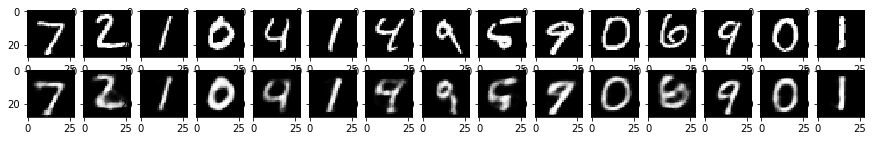

In [66]:
model = Autoencoder( n_features=28*28,
                     learning_rate= 0.005,
                     n_hidden=[64,16],
                     alpha=0.0,
                    )
model.fit(X=train_data.images,
          epochs=5,
          validation_data=(valid_data.images),
          test_data=(test_data.images),
          batch_size = 8,
         )

fig, axis = plt.subplots(2, 15, figsize=(15, 2))
for i in range(0,15):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

Epoch  1/ 5: 
[55000/55000] loss =    0.0332 , val_loss =    0.0389
Epoch  2/ 5: 
[55000/55000] loss =    0.0292 , val_loss =    0.0407
Epoch  3/ 5: 
[55000/55000] loss =    0.0269 , val_loss =    0.0385
Epoch  4/ 5: 
[55000/55000] loss =    0.0260 , val_loss =    0.0378
Epoch  5/ 5: 
[55000/55000] loss =    0.0249 , val_loss =    0.0373
test_loss =    0.0149


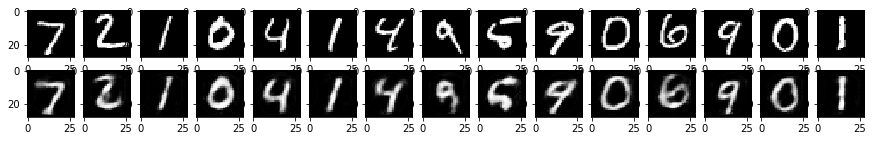

In [69]:
model2 = Autoencoder( n_features=28*28,
                     learning_rate= 0.005,
                     n_hidden=[64,16],
                     alpha=0.2,
                    )
model2.fit(X=train_data.images,
          epochs=5,
          validation_data=(valid_data.images),
          test_data=(test_data.images),
          batch_size = 8,
         )

fig, axis = plt.subplots(2, 15, figsize=(15, 2))
for i in range(0,15):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model2.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()

In [8]:
encode = model2.encode(test_data.images)
print(encode[0])

[ 0.16153094  0.92596656  0.99916625  0.18407701  0.9997378   0.98678648
  0.99493611  0.00565049  0.49653858  0.99797612  0.9941116   0.99573416
  0.97327864  0.98180598  0.67971194  0.99996698  0.07969672  0.9999994
  0.28558242  0.99535477  0.49200705  0.99145538  0.45877504  0.99436635
  0.00856398  0.42094052  0.99983776  0.3300631   0.21402548  0.67096198
  0.56077957  0.84070432  0.32630485  0.99903071  0.74717754  0.37090036
  0.99590921  0.02847119  0.39775816  0.99104857  0.99997735  0.89178711
  0.99866986  0.86530387  0.73937887  0.71504307  0.87168825  1.
  0.99901974  0.00821809  0.99747485  0.87762266  0.97224122  0.87844807
  0.32324076  0.39346349  0.00515429  0.99983358  0.56055486  0.86588007
  0.99190676  0.86589909  0.00555018  0.99779981  0.92593765  0.10595657
  0.23066716  0.99927956  0.00647018  0.81106627  0.82081521  0.78174931
  0.95337939  0.99999976  0.10582721  0.04825417  0.26747212  0.06129796
  0.55835855  0.68675327  0.98711967  0.7852177   0.18459493

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)